In [1]:
import os
import tensorflow as tf
import itertools
import numpy as np
from numpy import unravel_index
from random import choice, random, sample
from operator import itemgetter
np.random.seed(1337)  # for reproducibility
from keras.models import Sequential, Model, load_model
from keras.layers import Input, BatchNormalization, Reshape
from keras.layers import Dense, Dropout, Activation, Flatten, LocallyConnected2D
from keras.layers import Conv2D, MaxPooling2D, AlphaDropout, ConvLSTM2D, AvgPool2D, Conv2DTranspose, UpSampling2D
from keras.layers import add, concatenate, multiply
from keras.initializers import VarianceScaling, RandomUniform
from keras.optimizers import Adam, SGD, rmsprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils, multi_gpu_model
from keras.utils.vis_utils import plot_model
from keras.engine.topology import Container
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.regularizers import l1, l2
import keras.backend as K
K.set_image_dim_ordering('th')

from keras.callbacks import Callback, ReduceLROnPlateau, LearningRateScheduler, TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt
import time
%matplotlib notebook

Using TensorFlow backend.


In [2]:
class Ataxx:
    def __init__(self, board=None):
        if board is None:                  # if there is no initialization given
            self.data = np.zeros((7, 7))   # then generate a board with starting init, and black(-1) takes first turn
            self.data[0, 0] = -1           
            self.data[6, 6] = -1
            self.data[0, 6] = 1
            self.data[6, 0] = 1
        else:
            self.data = board
            
    def get_feature_map(self, turn):
        friendly_map = (self.data == turn).astype(float)
        opponent_map = (self.data == -turn).astype(float)
        return np.concatenate((friendly_map.reshape((1, 7, 7)), opponent_map.reshape((1, 7, 7))), axis=0)
    
    def get_mask(self, turn, init=0.001):   # zero(init) out all illegal move positions
        moves = self.get_moves(turn)
        moves = list(zip(*self.get_moves(turn)))
        if len(moves) == 0:
            return np.zeros((2, 7, 7))
        else:
            start_pos = tuple(zip(*moves[0]))
            end_pos = tuple(zip(*moves[1]))
            start_mask = np.ones((7, 7)) * init
            start_mask[start_pos] = 1
            end_mask = np.ones((7, 7)) * init
            end_mask[end_pos] = 1
            return np.concatenate((start_mask.reshape((1, 7, 7)), end_mask.reshape((1, 7, 7))), axis=0)
    
    def plot(self, is_next_move=False, turn=None):                        # plot the board
        image = self.data.copy()
        if is_next_move:
            if turn not in [-1, 1]:
                raise ValueError("Turn must be -1 or 1, or Must input a turn for next moves")
            else:
                next_moves = self.get_moves(turn)
                if len(next_moves) == 0:
                    raise ValueError("Game is over already")
                next_pos = list(zip(*next_moves))[1]
                for pos in next_pos:
                    image[pos] = turn / 2
        plt.imshow(image, cmap='gray')
        plt.xticks(range(7), range(7))
        plt.yticks(range(7), range(7))
        plt.show()
                
    def is_valid(self, turn, pos):
        if turn not in [-1, 1]:
            raise ValueError("Turn must be -1 or 1") 
        elif self.data[pos] != 0:
            return False
        else:
            for dr in range(-2, 3):
                for dc in range(-2, 3):
                    pos_tmp = (pos[0]+dr, pos[1]+dc)
                    if pos_tmp[0] >= 0 and pos_tmp[1] >= 0 and pos_tmp[0] < 7 and pos_tmp[1] < 7:
                        if self.data[pos_tmp] == turn:  # convert any piece of the opponent to 'turn'
                            return True
            return False
        
    def get_moves(self, turn):
        if turn not in [-1, 1]:
            raise ValueError("Turn must be -1 or 1")
        else:
            next_moves = []
            for r in range(7):
                for c in range(7):
                    has_duplicate_move = False      # move within the radius of one of another friendly piece is called
                    if self.is_valid(turn, (r, c)): # duplicate move
                        for dr in range(-2, 3):
                            for dc in range(-2, 3):
                                if abs(dr) <= 1 and abs(dc) <=1 and has_duplicate_move: 
                                    continue        # no need to record same move again
                                else:
                                    pos_tmp = (r+dr, c+dc)
                                    if pos_tmp[0] >= 0 and pos_tmp[1] >= 0 and pos_tmp[0] < 7 and pos_tmp[1] < 7:
                                        if self.data[pos_tmp] == turn:
                                            next_moves.append((pos_tmp, (r, c)))
            return next_moves
    
    def get_greedy_move(self, turn):
        moves = self.get_moves(turn)
        if len(moves) == 0:
            raise ValueError('No Possible Moves')
        store_data = self.data.copy()
        best_score = -1000000
        for move in moves:
            self.data = store_data.copy()
            self.move_to(turn, move[0], move[1])
            score = self.evaluate(turn, -turn)
            if score > best_score:
                best_move = move
                best_score = score
        self.data = store_data
        return best_move
        
    def move_to(self, turn, pos0, pos1):
        if turn not in [-1, 1]:
            raise ValueError("Turn must be -1 or 1") 
        elif not self.is_valid(turn, pos1):
            raise ValueError("This move: " + str((pos0, pos1)) + " of turn: " + str(turn) + " is invalid") 
        elif self.data[pos0] != turn:
            raise ValueError("The starting position is not your piece")
        else:
            dis = np.array(pos1) - np.array(pos0)    # check if is jump move or duplicate move
            if abs(dis[0]) > 1 or abs(dis[1]) > 1:   # jump move
                self.data[pos0] = 0
                self.data[pos1] = turn
            else:                                    # duplicate move
                self.data[pos1] = turn
            for dr in range(-1, 2):                  # infection mode!!!!
                for dc in range(-1, 2):
                    pos_tmp = (pos1[0]+dr, pos1[1]+dc)
                    if pos_tmp[0] >= 0 and pos_tmp[1] >= 0 and pos_tmp[0] < 7 and pos_tmp[1] < 7:
                        if self.data[pos_tmp] == -turn:  # convert any piece of the opponent to 'turn'
                            self.data[pos_tmp] = turn
                            
    def simu_move_to(self, turn, pos0, pos1):
        if turn not in [-1, 1]:
            raise ValueError("Turn must be -1 or 1") 
        elif not self.is_valid(turn, pos1):
            raise ValueError("This move: " + str((pos0, pos1)) + " of turn: " + str(turn) + " is invalid") 
        elif self.data[pos0] != turn:
            raise ValueError("You are not moving your piece")
        else:
            tmp_data = self.data.copy()
            dis = np.array(pos1) - np.array(pos0)    # check if is jump move or duplicate move
            if abs(dis[0]) > 1 or abs(dis[1]) > 1:   # jump move
                tmp_data[pos0] = 0
                tmp_data[pos1] = turn
            else:                                    # duplicate move
                tmp_data[pos1] = turn
            for dr in range(-1, 2):                  # infection mode!!!!
                for dc in range(-1, 2):
                    pos_tmp = (pos1[0]+dr, pos1[1]+dc)
                    if pos_tmp[0] >= 0 and pos_tmp[1] >= 0 and pos_tmp[0] < 7 and pos_tmp[1] < 7:
                        if tmp_data[pos_tmp] == -turn:  # convert any piece of the opponent to 'turn'
                            tmp_data[pos_tmp] = turn
            return tmp_data
    
    def evaluate(self, turn, this_turn, max_score=100, min_score=0.1):
        if turn not in [-1, 1]:
            raise ValueError("Turn must be -1 or 1") 
        else:
            turn_no = 0
            op_no = 0
            for r in range(7):
                for c in range(7):
                    if self.data[r, c] == turn:
                        turn_no += 1
                    elif self.data[r, c] == -turn:
                        op_no += 1
            if turn_no + op_no == 49:
                if turn_no > op_no:
                    return max_score
                else:
                    return -max_score
            else:
                if len(self.get_moves(this_turn)) == 0:# if one of them can no longer move, count and end
                    if turn_no > op_no:
                        return max_score
                    else:
                        return -max_score
                else:
                    value = turn_no - op_no
            return value * min_score

In [3]:
class Relay():
    def __init__(self, max_size):
        self.relay = []
        self.max_size = max_size

    def reset(self):
        self.relay = []
        
    def add_sample(self, new_sample):
        if len(self.relay) >= self.max_size:
            self.relay.pop(0)
        self.relay.append(new_sample)
    
    def get_batch(self, batch_size):
        if len(self.relay) < batch_size:
            print('not enough sample')
            raise ValueError('relay not large enough')
        else:
            batch = sample(self.relay, batch_size)
            # generate random array to decide the orientation of the data augmentation
            is_flip = np.random.random(batch_size) < 0.5
            rot_times = (np.random.random(batch_size) * 4).astype(int)
            
            cur_state = np.array([self.augmentation(item[0], is_flip[i], rot_times[i]) 
                                  for i, item in enumerate(batch)]).reshape(-1, 2, 7, 7)
            cur_mask = np.array([self.augmentation(item[1], is_flip[i], rot_times[i])
                                 for i, item in enumerate(batch)]).reshape(-1, 2, 7, 7)
            cur_action = np.array([self.augmentation(item[2], is_flip[i], rot_times[i])
                                   for i, item in enumerate(batch)]).reshape(-1, 2, 7, 7)
            cur_reward = np.array([item[3] for item in batch]).reshape(-1)
            new_state = np.array([self.augmentation(item[4], is_flip[i], rot_times[i])
                                  for i, item in enumerate(batch)]).reshape(-1, 2, 7, 7)
            new_mask = np.array([self.augmentation(item[5], is_flip[i], rot_times[i])
                                  for i, item in enumerate(batch)]).reshape(-1, 2, 7, 7)
            return cur_state, cur_mask, cur_action, cur_reward, new_state, new_mask
    
    def augmentation(self, data, is_flip, rot_time): # data must have three dimentions and depth first
        if data is None:
            return None
        else:
            if is_flip:
                data = np.fliplr(data)
            data = np.rot90(data, k=rot_time, axes=(1, 2))
            return data
    
    def size(self):
        return len(self.relay)

# BatchNormalization helps in hard-to-tune lr situations

In [4]:
def neg_log_loss(y_true, y_pred):
    y_true = K.reshape(y_true, (-1, 1, 98))
    y_pred = K.reshape(y_pred, (-1, 1, 98))
    y_log = K.log(y_pred)
    y_concate = K.concatenate([y_true, y_log], axis=1)
    y_prod = K.prod(y_concate, axis=1)
    return -K.sum(y_prod)


class CriticNetwork(object):
    def __init__(self, TAU=0.001, LEARNING_RATE=0):
        self.TAU = TAU
        self.LEARNING_RATE = LEARNING_RATE

        #Now create the model
        with tf.device("/cpu:0"):
            self.model = self.create_critic_network() 
            self.target_model = self.create_critic_network() 
            self.target_model.set_weights(self.model.get_weights())
        
    def target_train(self):
        critic_weights = self.model.get_weights()
        critic_target_weights = self.target_model.get_weights()
        for i in range(len(critic_weights)):
            critic_target_weights[i] = self.TAU * critic_weights[i] + (1 - self.TAU)* critic_target_weights[i]
        self.target_model.set_weights(critic_target_weights)

    def create_critic_network(self):
        board_input = Input(shape=(2, 7, 7))
        x = Conv2D(32, (1, 1), activation='relu', padding='same')(board_input)
        x = BatchNormalization(axis=1)(x)
        board_feature = MaxPooling2D((2, 2))(x)

        action_input = Input(shape=(2, 7, 7))
        x = Conv2D(32, (1, 1), activation='relu', padding='same')(action_input)
        x = BatchNormalization(axis=1)(x)
        action_feature = MaxPooling2D((2, 2))(x)
        
        overall_feature = concatenate([board_input, action_input], axis=1)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(overall_feature)
        x = BatchNormalization(axis=1)(x)
        x = MaxPooling2D((2, 2))(x)
        
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization(axis=1)(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization(axis=1)(x)
        x = Flatten()(x)
        
        x = Dense(256, activation='relu')(x)
        x = BatchNormalization(axis=1)(x)
        x = Dense(1)(x)
        # construct model
        model = Model(inputs=[board_input, action_input], outputs=[x])
        print("actor")
        print(model.summary())
        # sgd = SGD(lr=self.LEARNING_RATE, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(loss='mse', optimizer=Adam(lr=self.LEARNING_RATE), metrics=['mse'])
        return model
    
class ActorNetwork(object):
    def __init__(self, TAU=0.001, LEARNING_RATE=0, pretrain_epoch=2, is_train=True, \
                 file_name='target_actor_model.h5'):
        if is_train:
            self.TAU = TAU
            self.LEARNING_RATE = LEARNING_RATE
            
            #Now create the model
            self.model= self.create_actor_network()   
            self.target_model= self.create_actor_network() 
            self.target_model.set_weights(self.model.get_weights())
            if not pretrain_epoch == 0:
                try:
                    self.model.load_weights('pretrained_actor_model.h5')
                    print("succesfully loaded the pretrained model")
                except:
                    print("start to pre train with greedy")
                    self.learn_rules(128, pretrain_epoch)
                    self.model.save_weights('pretrained_actor_model.h5')
        else:
            with tf.device("cpu:0"):
                self.target_model = load_model(file_name)
                print("successfully loaded trained target model")

    def save(self):
        self.target_model.save('target_actor_model.h5')

    def target_train(self):
        actor_weights = self.model.get_weights()
        actor_target_weights = self.target_model.get_weights()
        for i in range(len(actor_weights)):
            actor_target_weights[i] = self.TAU * actor_weights[i] + (1 - self.TAU)* actor_target_weights[i]
        self.target_model.set_weights(actor_target_weights)

    def create_actor_network(self):
        board_input = Input(shape=(2, 7, 7))
        mask_input = Input(shape=(2, 7, 7))
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(board_input)
        x = BatchNormalization(axis=1)(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization(axis=1)(x)
        x = MaxPooling2D((2, 2))(x)
        
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization(axis=1)(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization(axis=1)(x)
        x = Flatten()(x)
        
        x = Dense(98, activation='softplus')(x)
        x = Reshape((2, 7, 7))(x) 
        x = multiply(inputs=[x, mask_input])     # this mask will mask any illegal move
        x = Reshape((2, 49))(x)
        x = Activation('softmax')(x)
        x = Reshape((2, 7, 7))(x) 
        model = Model(input=[board_input, mask_input],output=[x])
        print(model.summary())
        # sgd = SGD(lr=self.LEARNING_RATE, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=1.)
        model.compile(loss=neg_log_loss, optimizer=Adam(lr=self.LEARNING_RATE))
        return model
    
    def get_action_prob(self, feature_map, action_mask, is_target=False):
        if not is_target:
            return self.model.predict([np.reshape(feature_map, (1, 2, 7, 7)), 
                                      np.reshape(action_mask, (1, 2, 7, 7))])[0]
        else:
            return self.target_model.predict([np.reshape(feature_map, (1, 2, 7, 7)), 
                                      np.reshape(action_mask, (1, 2, 7, 7))])[0]
    
    def get_stochastic_action(self, feature_map, action_mask, is_target=False):
        # get action_prob
        action_prob = self.get_action_prob(feature_map, action_mask, is_target)
        # get valid_moves list
        game = Ataxx(board=feature_map[0] - feature_map[1])
        valid_moves = game.get_moves(1)
        index_list = range(len(valid_moves))
        # store pred prob for each valid moves and sort it
        valid_moves_prob = np.zeros(len(valid_moves))
        for i, move in enumerate(valid_moves):
            valid_moves_prob[i] = action_prob[0][move[0]] + action_prob[1][move[1]]
        # noramlize probablity
        valid_moves_prob = valid_moves_prob / valid_moves_prob.sum()
        # sample a policy according to predicted prob
        move_index = np.random.choice(range(len(valid_moves)), p=valid_moves_prob)
        move = valid_moves[move_index]
        # generate 7*7 pos map
        start_pos = np.zeros((7, 7))
        start_pos[move[0]] = 1
        end_pos = np.zeros((7, 7))
        end_pos[move[1]] = 1
        return move[0], move[1], np.concatenate((start_pos.reshape(1, 7, 7), end_pos.reshape(1, 7, 7)), axis=0)
    
    def get_best_action(self, feature_map, action_mask, is_target=False, verbose=True):
        # get action_prob
        action_prob = self.get_action_prob(feature_map, action_mask, is_target)
        print("target!!!!")
        # get valid_moves list
        game = Ataxx(board=feature_map[0] - feature_map[1])
        valid_moves = game.get_moves(1)
        max_prob_sum = -1
        pos0 = (0, 0)
        pos1 = (0, 0)
        for move in valid_moves:
            tmp_prob_sum = action_prob[0][move[0]] + action_prob[1][move[1]]
            if tmp_prob_sum > max_prob_sum:
                max_prob_sum = tmp_prob_sum
                pos0 = move[0]
                pos1 = move[1]
        
        # output the max_prob
        if not verbose:
            r = np.random.random()
            if r < 0.01:
                print("confidence of this best move is: ", max_prob_sum)
        else:
            print("confidence of this best move is: ", max_prob_sum)
            
        # generate 7*7 pos map
        start_pos = np.zeros((7, 7))
        start_pos[pos0] = 1
        end_pos = np.zeros((7, 7))
        end_pos[pos1] = 1
        
        return pos0, pos1, np.concatenate((start_pos.reshape(1, 7, 7), end_pos.reshape(1, 7, 7)), axis=0)

    def data_generator(self, batch_size, max_size=5000):
        relay = Relay(max_size)
        game = Ataxx()
        turn = -1
        while True:            
            new_sample = []
            new_sample.append(game.get_feature_map(turn))
            new_sample.append(game.get_mask(turn))
            
            try:
                greedy_move = game.get_greedy_move(turn)
            except:
                game = Ataxx()
                turn = -1
                continue
            start_prob_map = np.zeros((7, 7))
            start_prob_map[greedy_move[0]] = 1
            end_prob_map = np.zeros((7, 7))
            end_prob_map[greedy_move[1]] = 1
                
            new_sample.append(np.concatenate((start_prob_map.reshape(1, 7, 7), end_prob_map.reshape(1, 7, 7)), axis=0))
            new_sample.append(new_sample[-1])
            new_sample.extend([None, None])
            relay.add_sample(new_sample)
            
            move = choice(game.get_moves(turn))
            game.move_to(turn, move[0], move[1])
            turn = -turn
            
            if relay.size() > batch_size:
                state, mask, action, _, _, _ = relay.get_batch(batch_size)
                yield [state, mask], action  
                
    def learn_rules(self, batch_size, epochs=10):
        game = Ataxx()
        print("original action prob map predicted by initial model for a starting game")
        print(self.get_action_prob(game, -1))
        sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
        gpu_model = multi_gpu_model(self.model, gpus=4)
        gpu_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])
        gpu_model.fit_generator(self.data_generator(batch_size), steps_per_epoch=1000, epochs=epochs, 
                                    verbose=1,
                                    validation_data=self.data_generator(32), 
                                    validation_steps=1,
                                    workers=8,
                                    use_multiprocessing=True,
                                    callbacks=[ReduceLROnPlateau(cooldown=5, min_lr=0.01, patience=2)])
        game = Ataxx()
        print("trained action prob map predicted by initial model for a starting game")
        print(self.get_action_prob(game, -1))

In [5]:
import keras.losses
keras.losses.neg_log_loss = neg_log_loss
actor0 = ActorNetwork(is_train=False, file_name='target_actor_model.h5')

successfully loaded trained target model


In [10]:
actor1 = ActorNetwork(is_train=False, file_name='target_actor_model_300_train.h5')

successfully loaded trained target model


-1 is actor0
0.0


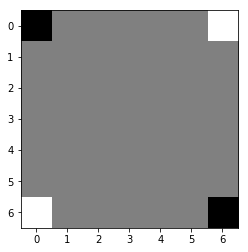

target!!!!
confidence of this best move is:  2.0
0.0


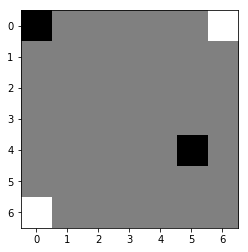

target!!!!
confidence of this best move is:  1.14096
-0.1


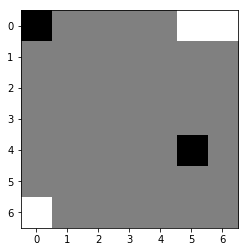

target!!!!
confidence of this best move is:  1.37503
-0.1


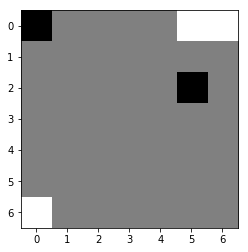

target!!!!
confidence of this best move is:  0.765131
-0.4


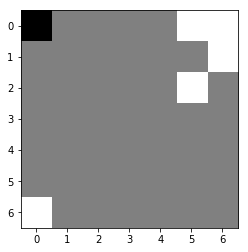

target!!!!
confidence of this best move is:  0.217631
-0.4


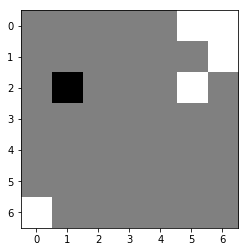

target!!!!
confidence of this best move is:  1.46196
-0.5


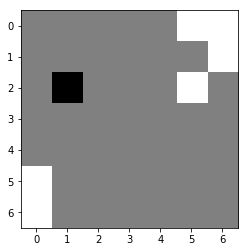

target!!!!
confidence of this best move is:  0.893392
-0.5


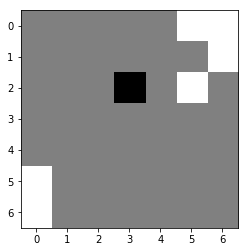

target!!!!
confidence of this best move is:  1.14188
-100


In [14]:
game = Ataxx()
turn = -1
print("-1 is actor0")
while abs(game.evaluate(turn, turn)) != 100:
    print(game.evaluate(-1, turn))
    game.plot()
    if turn == 1:
        actor = actor0
    else:
        actor = actor1
    with tf.device("/cpu:0"):
        pos0, pos1, _ = actor.get_best_action(game.get_feature_map(turn), game.get_mask(turn), \
                                              is_target=True)
    game.move_to(turn, pos0, pos1)
    turn = -turn
    time.sleep(0.1)
print(game.evaluate(-1, turn))

1 is actor
0.0


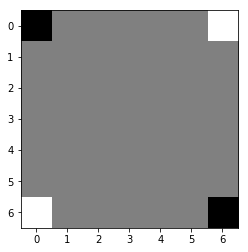

0.1


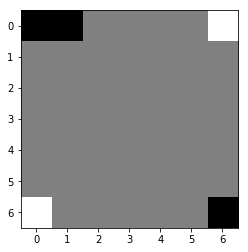

target!!!!
confidence of this best move is:  2.0
0.1


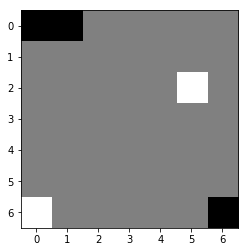

0.2


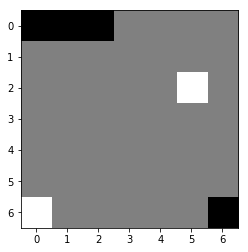

target!!!!
confidence of this best move is:  2.0
0.2


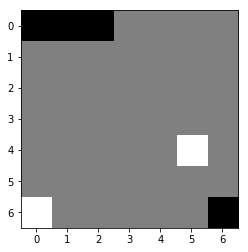

0.5


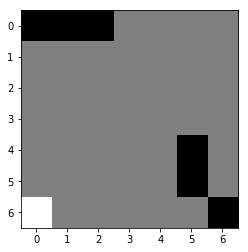

target!!!!
confidence of this best move is:  0.111747
0.4


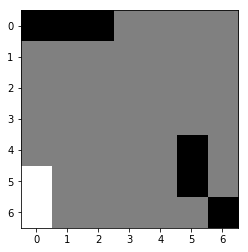

0.5


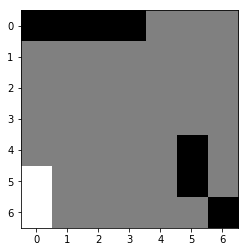

target!!!!
confidence of this best move is:  0.129221
0.5


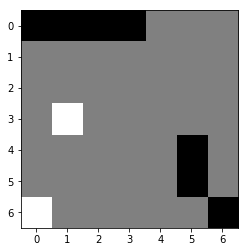

0.7000000000000001


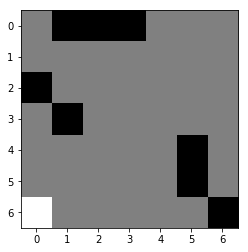

target!!!!
confidence of this best move is:  0.0643952
0.6000000000000001


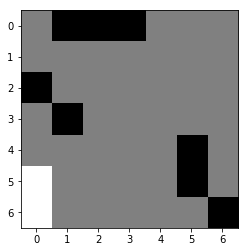

100


In [16]:
game = Ataxx()
turn = -1
print("1 is actor")
actor = actor1
while abs(game.evaluate(turn, turn)) != 100:
    print(game.evaluate(-1, turn))
    game.plot()
    if turn == -1:
        best_move = game.get_greedy_move(turn)
        game.move_to(turn, best_move[0], best_move[1])
    else:
        pos0, pos1, _ = actor.get_best_action(game.get_feature_map(turn), game.get_mask(turn), \
                                              is_target=True)
        game.move_to(turn, pos0, pos1)
    turn = -turn
    time.sleep(0.1)
print(game.evaluate(-1, turn))

-1 is actor
0.0


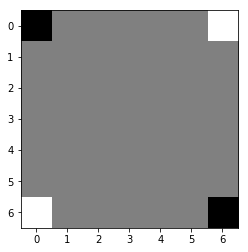

target!!!!
confidence of this best move is:  2.0
0.0


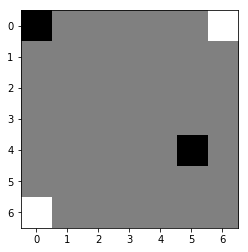

-0.1


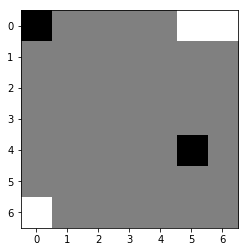

target!!!!
confidence of this best move is:  1.37503
-0.1


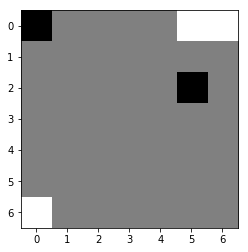

-0.4


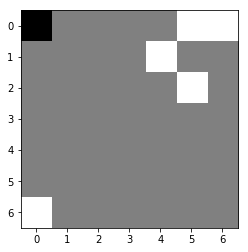

target!!!!
confidence of this best move is:  0.346101
-0.4


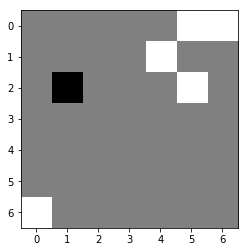

-100


In [17]:
game = Ataxx()
turn = -1
print("-1 is actor")
actor = actor1
while abs(game.evaluate(turn, turn)) != 100:
    print(game.evaluate(-1, turn))
    game.plot()
    if turn == 1:
        best_move = game.get_greedy_move(turn)
        game.move_to(turn, best_move[0], best_move[1])
    else:
        pos0, pos1, _ = actor.get_best_action(game.get_feature_map(turn), game.get_mask(turn), \
                                              is_target=True)
        game.move_to(turn, pos0, pos1)
    turn = -turn
    time.sleep(0.1)
print(game.evaluate(-1, turn))